# Extracting Image features

In [2]:
# Imports
import os
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline  

plt.style.use('fivethirtyeight')

In [4]:
def walk_up_folder(path, depth=1):
    """
    Helper method to navigate the file system and get to the file location
    """
    _cur_depth = 1        
    while _cur_depth < depth:
        path = os.path.dirname(path)
        _cur_depth += 1
    return path

In [11]:
data_path = os.path.join(walk_up_folder(os.getcwd(), depth=1),'Data/product_data.json')

with open(data_path, encoding='utf-8') as data_file:
    data = json.loads(data_file.read())

In [14]:
def blank_image():
    """
    Loads a blank image indicating missing file
    """
    return Image.fromarray(np.zeros((200,200,3), dtype="uint8"), 'RGB')

In [140]:
import PIL
from PIL import Image
import requests
from io import BytesIO
import urllib.request
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [8]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [112]:
images=[]
for i in range(len(data)):
    url=data[i]['images_url']
    if url.startswith("//"):
        url ="https://"+url[2:]
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        # Making sure all images are of the same dimensions
        if img.size!=(200,200):
            img=img.resize((200, 200), PIL.Image.ANTIALIAS)
        images.append(img)
    except:
        images.append(blank_image())
        continue

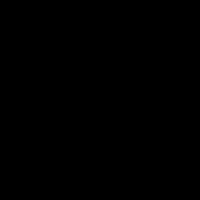

In [55]:
images[287]

In [56]:
img_to_array(images[287]).shape

(200, 200, 3)

In [59]:
img_to_array(images[0]).reshape(-1).reshape(1,3,200,200)

array([[[[ 247.,  247.,  247., ...,  249.,  249.,  249.],
         [ 249.,  249.,  249., ...,   47.,   32.,   85.],
         [  49.,   37.,   84., ...,  249.,  249.,  249.],
         ..., 
         [   0.,    0.,   61., ...,  251.,  251.,  251.],
         [ 250.,  250.,  250., ...,  251.,  251.,  251.],
         [ 251.,  251.,  251., ...,  150.,  132.,   54.]],

        [[   8.,    0.,  117., ...,  251.,  251.,  251.],
         [ 250.,  250.,  250., ...,  251.,  251.,  251.],
         [ 251.,  251.,  251., ...,  155.,  137.,   44.],
         ..., 
         [ 183.,  234.,  197., ...,  226.,  217.,  233.],
         [ 215.,  205.,  228., ...,  251.,  251.,  251.],
         [ 250.,  250.,  250., ...,  178.,  229.,  192.]],

        [[ 184.,  234.,  197., ...,  228.,  220.,  230.],
         [ 212.,  202.,  227., ...,  251.,  251.,  251.],
         [ 250.,  250.,  250., ...,  178.,  228.,  191.],
         ..., 
         [ 248.,  248.,  248., ...,  250.,  255.,  255.],
         [ 251.,  255.,

In [89]:
dataset = np.ndarray(shape=(1000, 3, 200, 200),dtype=np.float32)

In [128]:
print(images[300].size)

(200, 200)


In [131]:
img_to_array(images[330]).shape

(200, 200, 4)

In [125]:
import cv2
cv2.cvtColor(img_to_array(images[330]), cv2.COLOR_BGRA2BGR).shape

(200, 200, 3)

In [107]:
images[19].resize((200, 200), PIL.Image.ANTIALIAS).size

(200, 200)

# Loading the Dataset

In [133]:
# Loading the image data
for i in range(len(data)):
    url=data[i]['images_url']
    if url.startswith("//"):
        url ="https://"+url[2:]
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        # Making sure all images are of the same dimensions
        if img.size!=(200,200):
            img=img.resize((200, 200), PIL.Image.ANTIALIAS)
        x = img_to_array(img)
        # In case of grayScale images the len(img.shape) == 2
        if len(x.shape) > 2 and x.shape[2] == 4:
            #convert the image from RGBA2RGB
            x = cv2.cvtColor(x, cv2.COLOR_BGRA2BGR)  
    except:
        x=img_to_array(blank_image())
        pass
    x = (x - 128.0) / 128.0
    print(i,x.shape)
    dataset[i] = np.rollaxis(x, axis=2, start=0)   # this is a Numpy array with shape (3, 200, 200)

0 (200, 200, 3)
1 (200, 200, 3)
2 (200, 200, 3)
3 (200, 200, 3)
4 (200, 200, 3)
5 (200, 200, 3)
6 (200, 200, 3)
7 (200, 200, 3)
8 (200, 200, 3)
9 (200, 200, 3)
10 (200, 200, 3)
11 (200, 200, 3)
12 (200, 200, 3)
13 (200, 200, 3)
14 (200, 200, 3)
15 (200, 200, 3)
16 (200, 200, 3)
17 (200, 200, 3)
18 (200, 200, 3)
19 (200, 200, 3)
20 (200, 200, 3)
21 (200, 200, 3)
22 (200, 200, 3)
23 (200, 200, 3)
24 (200, 200, 3)
25 (200, 200, 3)
26 (200, 200, 3)
27 (200, 200, 3)
28 (200, 200, 3)
29 (200, 200, 3)
30 (200, 200, 3)
31 (200, 200, 3)
32 (200, 200, 3)
33 (200, 200, 3)
34 (200, 200, 3)
35 (200, 200, 3)
36 (200, 200, 3)
37 (200, 200, 3)
38 (200, 200, 3)
39 (200, 200, 3)
40 (200, 200, 3)
41 (200, 200, 3)
42 (200, 200, 3)
43 (200, 200, 3)
44 (200, 200, 3)
45 (200, 200, 3)
46 (200, 200, 3)
47 (200, 200, 3)
48 (200, 200, 3)
49 (200, 200, 3)
50 (200, 200, 3)
51 (200, 200, 3)
52 (200, 200, 3)
53 (200, 200, 3)
54 (200, 200, 3)
55 (200, 200, 3)
56 (200, 200, 3)
57 (200, 200, 3)
58 (200, 200, 3)
59 (200

463 (200, 200, 3)
464 (200, 200, 3)
465 (200, 200, 3)
466 (200, 200, 3)
467 (200, 200, 3)
468 (200, 200, 3)
469 (200, 200, 3)
470 (200, 200, 3)
471 (200, 200, 3)
472 (200, 200, 3)
473 (200, 200, 3)
474 (200, 200, 3)
475 (200, 200, 3)
476 (200, 200, 3)
477 (200, 200, 3)
478 (200, 200, 3)
479 (200, 200, 3)
480 (200, 200, 3)
481 (200, 200, 3)
482 (200, 200, 3)
483 (200, 200, 3)
484 (200, 200, 3)
485 (200, 200, 3)
486 (200, 200, 3)
487 (200, 200, 3)
488 (200, 200, 3)
489 (200, 200, 3)
490 (200, 200, 3)
491 (200, 200, 3)
492 (200, 200, 3)
493 (200, 200, 3)
494 (200, 200, 3)
495 (200, 200, 3)
496 (200, 200, 3)
497 (200, 200, 3)
498 (200, 200, 3)
499 (200, 200, 3)
500 (200, 200, 3)
501 (200, 200, 3)
502 (200, 200, 3)
503 (200, 200, 3)
504 (200, 200, 3)
505 (200, 200, 3)
506 (200, 200, 3)
507 (200, 200, 3)
508 (200, 200, 3)
509 (200, 200, 3)
510 (200, 200, 3)
511 (200, 200, 3)
512 (200, 200, 3)
513 (200, 200, 3)
514 (200, 200, 3)
515 (200, 200, 3)
516 (200, 200, 3)
517 (200, 200, 3)
518 (200, 

920 (200, 200, 3)
921 (200, 200, 3)
922 (200, 200, 3)
923 (200, 200, 3)
924 (200, 200, 3)
925 (200, 200, 3)
926 (200, 200, 3)
927 (200, 200, 3)
928 (200, 200, 3)
929 (200, 200, 3)
930 (200, 200, 3)
931 (200, 200, 3)
932 (200, 200, 3)
933 (200, 200, 3)
934 (200, 200, 3)
935 (200, 200, 3)
936 (200, 200, 3)
937 (200, 200, 3)
938 (200, 200, 3)
939 (200, 200, 3)
940 (200, 200, 3)
941 (200, 200, 3)
942 (200, 200, 3)
943 (200, 200, 3)
944 (200, 200, 3)
945 (200, 200, 3)
946 (200, 200, 3)
947 (200, 200, 3)
948 (200, 200, 3)
949 (200, 200, 3)
950 (200, 200, 3)
951 (200, 200, 3)
952 (200, 200, 3)
953 (200, 200, 3)
954 (200, 200, 3)
955 (200, 200, 3)
956 (200, 200, 3)
957 (200, 200, 3)
958 (200, 200, 3)
959 (200, 200, 3)
960 (200, 200, 3)
961 (200, 200, 3)
962 (200, 200, 3)
963 (200, 200, 3)
964 (200, 200, 3)
965 (200, 200, 3)
966 (200, 200, 3)
967 (200, 200, 3)
968 (200, 200, 3)
969 (200, 200, 3)
970 (200, 200, 3)
971 (200, 200, 3)
972 (200, 200, 3)
973 (200, 200, 3)
974 (200, 200, 3)
975 (200, 

In [136]:
dataset.shape

(1000, 3, 200, 200)

# Network Architecture

In [143]:
weight_file = os.path.join(walk_up_folder(os.getcwd(), depth=1),'Data/vgg16_weights.h5')

In [134]:
def get_base_model():
    """
    Returns the convolutional part of VGG net as a keras model 
    All layers have trainable set to False
    """
    img_width, img_height = 200, 200

    # build the VGG16 network
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height), name='image_input'))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # set trainable to false in all layers 
    for layer in model.layers:
        if hasattr(layer, 'trainable'):
            layer.trainable = False

    return model

def load_weights_in_base_model(model):
    """
    The function takes the VGG convolutian part and loads
    the weights from the pre-trained model and then returns the model
    """
    weight_file = os.path.join(walk_up_folder(os.getcwd(), depth=1),'Data/vgg16_weights.h5')
    f = h5py.File(weight_file)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    f.close()
    return model


In [148]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np

def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), dim_ordering="th"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), dim_ordering="th"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), dim_ordering="th"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), dim_ordering="th"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), dim_ordering="th"))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [149]:
model = VGG_16(weight_file)

ValueError: You are trying to load a weight file containing 0 layers into a model with 15 layers.